In [3]:
## Standard libraries
import os
import numpy as np
import random
import json
from PIL import Image
from collections import defaultdict
from statistics import mean, stdev
from copy import deepcopy

## Imports for plotting
import matplotlib.pyplot as plt
plt.set_cmap('cividis')
%matplotlib inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg', 'pdf') # For export
import matplotlib
matplotlib.rcParams['lines.linewidth'] = 2.0
import seaborn as sns
sns.reset_orig()

## tqdm for loading bars
from tqdm.auto import tqdm

## PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as optim
from torch.utils.data import DataLoader

## Torchvision
import torchvision
from torchvision.datasets import CIFAR100, SVHN
import torchvision.transforms as transforms
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])


In [4]:
CIFAR_train_set = CIFAR100(root="../data", train=True, download=True, transform=transforms.ToTensor())
CIFAR_test_set = CIFAR100(root="../data", train=False, download=True, transform=transforms.ToTensor())

Files already downloaded and verified
Files already downloaded and verified


In [5]:
CIFAR_all_images = np.concatenate([CIFAR_train_set.data, CIFAR_test_set.data], axis=0)
CIFAR_all_targets = torch.LongTensor(CIFAR_train_set.targets + CIFAR_test_set.targets)
print(CIFAR_all_targets)

tensor([19, 29,  0,  ..., 51, 42, 70])


In [6]:
print(CIFAR_all_images[0].shape)

(32, 32, 3)


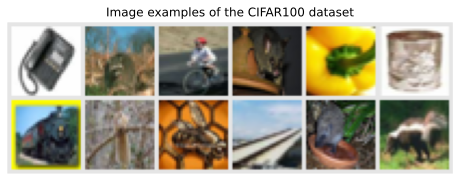

In [7]:
NUM_IMAGES = 12
CIFAR_images = torch.stack([CIFAR_train_set[np.random.randint(len(CIFAR_train_set))][0] for idx in range(NUM_IMAGES)], dim=0)
img_grid = torchvision.utils.make_grid(CIFAR_images, nrow=6, normalize=True, pad_value=0.9)
img_grid = img_grid.permute(1, 2, 0)

plt.figure(figsize=(8,8))
plt.title("Image examples of the CIFAR100 dataset")
plt.imshow(img_grid)
plt.axis('off')
plt.show()
plt.close()

In [8]:
torch.manual_seed(0)           # Set seed for reproducibility
classes = torch.randperm(100)  # Returns random permutation of numbers 0 to 99
train_classes, test_classes, val_classes = classes[:64], classes[64:80], classes[80:] #similar to miniImageNet

In [9]:
idx_to_class = {val: key for key, val in CIFAR_train_set.class_to_idx.items()}
print("Test classes:", [idx_to_class[c.item()] for c in val_classes])
print("Val classes:", [idx_to_class[c.item()] for c in test_classes])

Test classes: ['caterpillar', 'castle', 'skunk', 'ray', 'bus', 'motorcycle', 'keyboard', 'chimpanzee', 'possum', 'tiger', 'kangaroo', 'crocodile', 'butterfly', 'shark', 'forest', 'pickup_truck', 'telephone', 'lion', 'worm', 'mushroom']
Val classes: ['flatfish', 'fox', 'boy', 'apple', 'clock', 'bridge', 'television', 'mouse', 'couch', 'maple_tree', 'hamster', 'willow_tree', 'bottle', 'sweet_pepper', 'poppy', 'table']


#### Create a task from dataset randomly

In [10]:
# def createSplits(all_imgs, all_labels, k_shot):#, train_classes, test_classes, val_classes):
#     """
#     Inputs:
#         imgs - Numpy array of shape [N,32,32,3] containing all images.
#         targets - PyTorch array of shape [N] containing all labels.
#         k-shot - 
        
#     """
        
#     classes = torch.unique(all_labels).tolist()
#     data_by_classes = []
    
#     #organize by classes
#     for class_ in classes:
        
#         holder_array = []
#         if(class_ % 10 == 0): print(class_)
#         idx_array = [i for i, x in enumerate(all_labels) if x == class_]
# #         print(idx_array)
#         labels_for_class = [all_labels[i] for i in idx_array]
#         img_for_class = [all_imgs[i] for i in idx_array]
# #         print(len(img_for_class))
#         data_by_classes.append([img_for_class,labels_for_class])
            
    
#     #create tasks for train, test, and val
#     #train_classes may need to come from a split folder
    
#     train_by_class = []
#     test_by_class = []
#     val_by_class = []
#     train_by_class_q = []
#     test_by_class_q = []
#     val_by_class_q = []
    
    
#     random.shuffle(classes)
#     classes_for_tasks = classes
    
#     #To create Query Set 
    

#     train_classes, test_classes, val_classes = classes_for_tasks[:75], classes_for_tasks[75:90], classes_for_tasks[90:]
    
#     for data_by_class in data_by_classes:
        
#         class_in_set = data_by_class[1][0]
#         if(class_in_set in train_classes):
#             k_shot_indicies = random.sample(range(0,len(data_by_class[0])-k_shot-1), k_shot)
#             class_train_data = [[data_by_class[0][i], data_by_class[1][i]] for i in k_shot_indicies]
#             query_set_class_train = [[data_by_class[0][i], data_by_class[1][-i]] for i in range(1,k_shot+1)]
#             train_by_class_q.append(query_set_class_train)
#             train_by_class.append(class_train_data)
            
#         elif(class_in_set in test_classes):
            
#             k_shot_indicies = random.sample(range(0,len(data_by_class[0])-k_shot-1), k_shot)
#             class_test_data = [[data_by_class[0][i], data_by_class[1][i]] for i in k_shot_indicies]
#             query_set_class_test = [[data_by_class[0][-i], data_by_class[1][-i]] for i in range(1,k_shot+1)]
#             test_by_class_q.append(query_set_class_test)
#             test_by_class.append(class_test_data)
            
#         elif(class_in_set in val_classes):
            
#             k_shot_indicies = random.sample(range(0,len(data_by_class[0])-k_shot-1), k_shot)
#             class_val_data = [[data_by_class[0][i], data_by_class[1][i]] for i in k_shot_indicies]
#             query_set_class_val = [[data_by_class[0][-i], data_by_class[1][-i]] for i in range(1,k_shot+1)]
#             val_by_class_q.append(query_set_class_val)
#             val_by_class.append(class_val_data)
    
#     return train_by_class, test_by_class, val_by_class,train_by_class_q, test_by_class_q, val_by_class_q

# train_by_class, test_by_class, val_by_class,train_by_class_q, test_by_class_q, val_by_class_q = createSplits(CIFAR_all_images, CIFAR_all_targets, 5)

In [11]:
def createClassSplits(all_imgs, all_labels):#, train_classes, test_classes, val_classes):
    """
    Inputs:
        imgs - Numpy array of shape [N,32,32,3] containing all images.
        targets - PyTorch array of shape [N] containing all labels.
        k-shot - 
        
    """
        
    classes = torch.unique(all_labels).tolist()
    data_by_classes = []
    print(classes)

    for class_ in classes:
        
        holder_array = []
        if(class_ % 10 == 0): print(class_)
        idx_array = [i for i, x in enumerate(all_labels) if x == class_]

        labels_for_class = [all_labels[i] for i in idx_array]
        img_for_class = [all_imgs[i] for i in idx_array]
        combined_by_class =[]

        combined_by_class = [[img_for_class[i],labels_for_class[i]] for i in range(len(img_for_class))]

        data_by_classes.append(combined_by_class)
            
    return data_by_classes

In [12]:
data_by_classes = createClassSplits(CIFAR_all_images, CIFAR_all_targets)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99]
0
10
20
30
40
50
60
70
80
90


In [20]:
def sampleTasks(data_by_class, k_shots, n_way):
    task_extra = random.sample(data_by_classes, n_way)
    task_ss = []
    task_q = []
    for by_class in task_extra:

        samples = random.sample(by_class, 2*k_shots)

        task_ss = task_ss + samples[:k_shots]
        task_q = task_q +samples[k_shots:k_shots+3]
        
    random.shuffle(task_ss)
    random.shuffle(task_q)
    
    return task_ss, task_q[:3*k_shots]
    

In [ ]:
# def createTasks(training_data_ss, training_data_q, n_way, k_shots):
    
#     no_tasks = len(training_data_ss)/n_way
    
#     classes = [element[0][1] for element in training_data_ss]

#     c = list(zip(training_data_ss, training_data_q))

#     random.shuffle(c)

#     training_data_ss, training_data_q = zip(*c)

#     tasks = []

#     for i in range(int(len(classes)/n_way)):
#         task_dic = {}
#         task_holder_ss = []
#         task_holder_q = []
#         if(n_way*(i+1)-1 < len(classes)):   
#             for j in range(n_way):
#                 task_holder_ss= [*task_holder_ss, *training_data_ss[n_way*i+j]]
#                 task_holder_q= [*task_holder_ss, *training_data_q[n_way*i+j]]
#         else:
#             last_index_p1 = len(classes)
            
#             for j in range(n_way*(i), last_index_p1):
#                 task_holder_ss= [*task_holder_ss, *training_data_ss[n_way*i+j]]
#                 task_holder_q= [*task_holder_ss, *training_data_q[n_way*i+j]]
#         random.shuffle(task_holder_ss)
#         random.shuffle(task_holder_q)
#         task_dic['support'] = task_holder_ss
#         task_dic['query'] = task_holder_q[:3*k_shots]
        
#         tasks.append(task_dic)
    
#     return tasks

# train_tasks = createTasks(train_by_class, train_by_class_q, 5, 5)
# test_tasks = createTasks(test_by_class, test_by_class_q, 5, 5)
# val_tasks = createTasks(val_by_class, val_by_class_q, 5, 5)

In [14]:
image_data = train_tasks[0]['support'][0][0]
# print(image_data)
plt.imshow(image_data)

NameError: name 'train_tasks' is not defined

In [15]:
import  torch
from    torch import nn
from    torch.nn import functional as F
import  numpy as np


# """
# Taken From:

# @misc{MAML_Pytorch,
#   author = {Liangqu Long},
#   title = {MAML-Pytorch Implementation},
#   year = {2018},
#   publisher = {GitHub},
#   journal = {GitHub repository},
#   howpublished = {\url{https://github.com/dragen1860/MAML-Pytorch}},
#   commit = {master}
# }

# """


class Learner(nn.Module):

    def __init__(self, config, imgc, imgsz):
        """
        :param config: network config file, type:list of (string, list)
        :param imgc: 1 or 3
        :param imgsz:  28 or 84
        """
        super(Learner, self).__init__()


        self.config = config

        # this dict contains all tensors needed to be optimized
        self.vars = nn.ParameterList()
        # running_mean and running_var
        self.vars_bn = nn.ParameterList()

        for i, (name, param) in enumerate(self.config):
            if name is 'conv2d':
                # [ch_out, ch_in, kernelsz, kernelsz]
                w = nn.Parameter(torch.ones(*param[:4]))
                # gain=1 according to cbfin's implementation
                torch.nn.init.kaiming_normal_(w)
                self.vars.append(w)
                # [ch_out]
                self.vars.append(nn.Parameter(torch.zeros(param[0])))

            elif name is 'convt2d':
                # [ch_in, ch_out, kernelsz, kernelsz, stride, padding]
                w = nn.Parameter(torch.ones(*param[:4]))
                # gain=1 according to cbfin's implementation
                torch.nn.init.kaiming_normal_(w)
                self.vars.append(w)
                # [ch_in, ch_out]
                self.vars.append(nn.Parameter(torch.zeros(param[1])))

            elif name is 'linear':
                # [ch_out, ch_in]
                w = nn.Parameter(torch.ones(*param))
                # gain=1 according to cbfinn's implementation
                torch.nn.init.kaiming_normal_(w)
                self.vars.append(w)
                # [ch_out]
                self.vars.append(nn.Parameter(torch.zeros(param[0])))

            elif name is 'bn':
                # [ch_out]
                w = nn.Parameter(torch.ones(param[0]))
                self.vars.append(w)
                # [ch_out]
                self.vars.append(nn.Parameter(torch.zeros(param[0])))

                # must set requires_grad=False
                running_mean = nn.Parameter(torch.zeros(param[0]), requires_grad=False)
                running_var = nn.Parameter(torch.ones(param[0]), requires_grad=False)
                self.vars_bn.extend([running_mean, running_var])


            elif name in ['tanh', 'relu', 'upsample', 'avg_pool2d', 'max_pool2d',
                          'flatten', 'reshape', 'leakyrelu', 'sigmoid']:
                continue
            else:
                raise NotImplementedError






    def extra_repr(self):
        info = ''

        for name, param in self.config:
            if name is 'conv2d':
                tmp = 'conv2d:(ch_in:%d, ch_out:%d, k:%dx%d, stride:%d, padding:%d)'\
                      %(param[1], param[0], param[2], param[3], param[4], param[5],)
                info += tmp + '\n'

            elif name is 'convt2d':
                tmp = 'convTranspose2d:(ch_in:%d, ch_out:%d, k:%dx%d, stride:%d, padding:%d)'\
                      %(param[0], param[1], param[2], param[3], param[4], param[5],)
                info += tmp + '\n'

            elif name is 'linear':
                tmp = 'linear:(in:%d, out:%d)'%(param[1], param[0])
                info += tmp + '\n'

            elif name is 'leakyrelu':
                tmp = 'leakyrelu:(slope:%f)'%(param[0])
                info += tmp + '\n'


            elif name is 'avg_pool2d':
                tmp = 'avg_pool2d:(k:%d, stride:%d, padding:%d)'%(param[0], param[1], param[2])
                info += tmp + '\n'
            elif name is 'max_pool2d':
                tmp = 'max_pool2d:(k:%d, stride:%d, padding:%d)'%(param[0], param[1], param[2])
                info += tmp + '\n'
            elif name in ['flatten', 'tanh', 'relu', 'upsample', 'reshape', 'sigmoid', 'use_logits', 'bn']:
                tmp = name + ':' + str(tuple(param))
                info += tmp + '\n'
            else:
                raise NotImplementedError

        return info



    def forward(self, x, vars=None, bn_training=True):
        """
        This function can be called by finetunning, however, in finetunning, we dont wish to update
        running_mean/running_var. Thought weights/bias of bn is updated, it has been separated by fast_weights.
        Indeed, to not update running_mean/running_var, we need set update_bn_statistics=False
        but weight/bias will be updated and not dirty initial theta parameters via fast_weiths.
        :param x: [b, 1, 28, 28]
        :param vars:
        :param bn_training: set False to not update
        :return: x, loss, likelihood, kld
        """

        if vars is None:
            vars = self.vars

        idx = 0
        bn_idx = 0

        for name, param in self.config:
            if name is 'conv2d':
                w, b = vars[idx], vars[idx + 1]
                # remember to keep synchrozied of forward_encoder and forward_decoder!
                x = F.conv2d(x, w, b, stride=param[4], padding=param[5])
                idx += 2
                # print(name, param, '\tout:', x.shape)
            elif name is 'convt2d':
                w, b = vars[idx], vars[idx + 1]
                # remember to keep synchrozied of forward_encoder and forward_decoder!
                x = F.conv_transpose2d(x, w, b, stride=param[4], padding=param[5])
                idx += 2
                # print(name, param, '\tout:', x.shape)
            elif name is 'linear':
                w, b = vars[idx], vars[idx + 1]
                x = F.linear(x, w, b)
                idx += 2
                # print('forward:', idx, x.norm().item())
            elif name is 'bn':
                w, b = vars[idx], vars[idx + 1]
                running_mean, running_var = self.vars_bn[bn_idx], self.vars_bn[bn_idx+1]
                x = F.batch_norm(x, running_mean, running_var, weight=w, bias=b, training=bn_training)
                idx += 2
                bn_idx += 2

            elif name is 'flatten':
                # print(x.shape)
                x = x.view(x.size(0), -1)
            elif name is 'reshape':
                # [b, 8] => [b, 2, 2, 2]
                x = x.view(x.size(0), *param)
            elif name is 'relu':
                x = F.relu(x, inplace=param[0])
            elif name is 'leakyrelu':
                x = F.leaky_relu(x, negative_slope=param[0], inplace=param[1])
            elif name is 'tanh':
                x = F.tanh(x)
            elif name is 'sigmoid':
                x = torch.sigmoid(x)
            elif name is 'upsample':
                x = F.upsample_nearest(x, scale_factor=param[0])
            elif name is 'max_pool2d':
                x = F.max_pool2d(x, param[0], param[1], param[2])
            elif name is 'avg_pool2d':
                x = F.avg_pool2d(x, param[0], param[1], param[2])

            else:
                raise NotImplementedError

        # make sure variable is used properly
        assert idx == len(vars)
        assert bn_idx == len(self.vars_bn)


        return x


    def zero_grad(self, vars=None):
        """
        :param vars:
        :return:
        """
        with torch.no_grad():
            if vars is None:
                for p in self.vars:
                    if p.grad is not None:
                        p.grad.zero_()
            else:
                for p in vars:
                    if p.grad is not None:
                        p.grad.zero_()

    def parameters(self):
        """
        override this function since initial parameters will return with a generator.
        :return:
        """
        return self.vars


<>:42: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:51: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:60: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:69: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:97: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:102: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:107: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:111: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:116: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:119: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:151: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:157: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:163: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:168: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:175: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:178: SyntaxWarning: "is" with a literal. Did you mean "==

In [50]:
n_ways = 5
# [ch_in, ch_out, kernelsz, kernelsz, stride, padding] 256, 128, 64, 64

config_small = [
    ('conv2d', [32, 3, 3, 3, 2, 0]),
    ('relu', [True]),
    ('bn', [32]),
    ('conv2d', [32, 32, 3, 3, 2, 0]),
    ('relu', [True]),
    ('bn', [32]),
    ('conv2d', [32, 32, 3, 3, 2, 0]),
    ('relu', [True]),
    ('bn', [32]),
    ('conv2d', [32, 32, 2, 2, 1, 0]),
    ('relu', [True]),
    ('bn', [32]),
    ('flatten', []),
    ('linear', [n_ways, 4*32])
]
config_big = [
    ('conv2d', [256, 3, 3, 3, 2, 0]),
    ('relu', [True]),
    ('bn', [256]),
    ('conv2d', [128, 256, 3, 3, 2, 0]),
    ('relu', [True]),
    ('bn', [128]),
    ('conv2d', [64, 128, 3, 3, 2, 0]),
    ('relu', [True]),
    ('bn', [64]),
    ('conv2d', [64, 64, 2, 2, 1, 0]),
    ('relu', [True]),
    ('bn', [64]),
    ('flatten', []),
    ('linear', [n_ways, 4*64])
]

In [51]:
from datetime import datetime
start = datetime.now()
model = Learner(config_small,3,32)
meta_iter = 10000
meta_lr = 1e-3
meta_opt = torch.optim.SGD(model.parameters(), lr = 1e-3)

train_by_classes = data_by_classes[:64]
test_by_classes = data_by_classes[64:85]
val_by_classes = data_by_classes[85:]

for i in range(meta_iter):    
    outer_loss = 0
    num_tasks = 4
    for task in range(num_tasks):
        task_ss, task_q = sampleTasks(train_by_classes, 5, 5)
    
        train_dataloader = DataLoader(task_ss, batch_size = len(task_ss), shuffle = True)
        test_dataloader = DataLoader(task_q, batch_size = len(task_q), shuffle = True)

        train_inputs, train_targets = iter(train_dataloader).next()
        train_classes_map = torch.unique(train_targets).tolist()
        map_ = {x: i for i, x in enumerate(train_classes_map)}
        
        train_targets = torch.tensor([map_[x.item()] for x in train_targets])
        train_inputs = torch.transpose(train_inputs,1,3).type(torch.FloatTensor)
        
        test_inputs, test_targets = iter(test_dataloader).next()
        
        test_inputs = torch.transpose(test_inputs,1,3).type(torch.FloatTensor)
        test_targets = torch.tensor([map_[x.item()] for x in test_targets])

        train_logits = model(train_inputs, bn_training=True)
        inner_loss = F.cross_entropy(train_logits, train_targets)

        model.zero_grad()
        grad = torch.autograd.grad(inner_loss, model.parameters())
        fast_weights = list(map(lambda p: p[1] - meta_lr * p[0], zip(grad, model.parameters())))

        test_logits = model(test_inputs, fast_weights, bn_training=True)
        outer_loss += F.cross_entropy(test_logits, test_targets)
        
    if(i % 500 ==0): print(f"Outer_loss at {i}: ",outer_loss/5)
        
    meta_opt.zero_grad()
    outer_loss.backward()
    meta_opt.step()
    
print(datetime.now()-start)

torch.Size([25, 3, 32, 32])
torch.Size([25, 3, 32, 32])
torch.Size([25, 3, 32, 32])
torch.Size([25, 3, 32, 32])
Outer_loss at 0:  tensor(1.9130, grad_fn=<DivBackward0>)
torch.Size([25, 3, 32, 32])
torch.Size([25, 3, 32, 32])
torch.Size([25, 3, 32, 32])
torch.Size([25, 3, 32, 32])
torch.Size([25, 3, 32, 32])
torch.Size([25, 3, 32, 32])
torch.Size([25, 3, 32, 32])
torch.Size([25, 3, 32, 32])
torch.Size([25, 3, 32, 32])
torch.Size([25, 3, 32, 32])
torch.Size([25, 3, 32, 32])
torch.Size([25, 3, 32, 32])
torch.Size([25, 3, 32, 32])
torch.Size([25, 3, 32, 32])
torch.Size([25, 3, 32, 32])
torch.Size([25, 3, 32, 32])
torch.Size([25, 3, 32, 32])
torch.Size([25, 3, 32, 32])
torch.Size([25, 3, 32, 32])
torch.Size([25, 3, 32, 32])
torch.Size([25, 3, 32, 32])
torch.Size([25, 3, 32, 32])
torch.Size([25, 3, 32, 32])
torch.Size([25, 3, 32, 32])
torch.Size([25, 3, 32, 32])
torch.Size([25, 3, 32, 32])
torch.Size([25, 3, 32, 32])
torch.Size([25, 3, 32, 32])
torch.Size([25, 3, 32, 32])
torch.Size([25, 3, 

KeyboardInterrupt: 

In [ ]:
import copy
print(i)
model_ft_1 = copy.deepcopy(model)
torch.save(model.state_dict(), f"MAML_CIFAR_FS_5shot1way_{i+1}MetaIter_Q3_SmallCNN")

In [39]:
# model_big = Learner(config_big,3,32)
# model_big.load_state_dict(torch.load("MAML_CIFAR_FS_5000MetaIter_Q15"))
# # model_big = torch.load("MAML_CIFAR_FS_5000MetaIter_Q15")
# model_big.train()
model_small = Learner(config_small,3,32)
model_small.load_state_dict(torch.load(f"MAML_CIFAR_FS_5shot1way_10000MetaIter_Q3_SmallCNN"))
# model_big = torch.load("MAML_CIFAR_FS_5000MetaIter_Q15")
model_small.train()

/Users/Neel/opt/anaconda3/lib/python3.8/site-packages/torch/nn/modules/container.py:435: UserWarning: Setting attributes on ParameterList is not supported.
  warnings.warn("Setting attributes on ParameterList is not supported.")


Learner(
  conv2d:(ch_in:3, ch_out:32, k:3x3, stride:2, padding:0)
  relu:(True,)
  bn:(32,)
  conv2d:(ch_in:32, ch_out:32, k:3x3, stride:2, padding:0)
  relu:(True,)
  bn:(32,)
  conv2d:(ch_in:32, ch_out:32, k:3x3, stride:2, padding:0)
  relu:(True,)
  bn:(32,)
  conv2d:(ch_in:32, ch_out:32, k:2x2, stride:1, padding:0)
  relu:(True,)
  bn:(32,)
  flatten:()
  linear:(in:128, out:5)
  
  (vars): ParameterList(
      (0): Parameter containing: [torch.FloatTensor of size 32x3x3x3]
      (1): Parameter containing: [torch.FloatTensor of size 32]
      (2): Parameter containing: [torch.FloatTensor of size 32]
      (3): Parameter containing: [torch.FloatTensor of size 32]
      (4): Parameter containing: [torch.FloatTensor of size 32x32x3x3]
      (5): Parameter containing: [torch.FloatTensor of size 32]
      (6): Parameter containing: [torch.FloatTensor of size 32]
      (7): Parameter containing: [torch.FloatTensor of size 32]
      (8): Parameter containing: [torch.FloatTensor of size 3

### Fine Tune with Ten Step

In [41]:
import copy
total_acc = 0
test_num = 100
for i in range(test_num):
    querysz = 3
    update_step_test = 10
    corrects = [0 for _ in range(update_step_test + 1)]
    update_lr = 1e-1
    model_ft_2 = copy.deepcopy(model)
    
    task_ss, task_q = sampleTasks(val_by_classes, 1, 5)
    train_dataloader = DataLoader(task_ss, batch_size = 5, shuffle = True)
    test_dataloader = DataLoader(task_q, batch_size = querysz, shuffle = True)

    train_inputs, train_targets = iter(train_dataloader).next()
    train_classes_map = torch.unique(train_targets).tolist()
    map_ = {x: i for i, x in enumerate(train_classes_map)}
    train_targets = torch.tensor([map_[x.item()] for x in train_targets])
    train_inputs = torch.transpose(train_inputs,1,3).type(torch.FloatTensor)

    test_inputs, test_targets = iter(test_dataloader).next()
    test_inputs = torch.transpose(test_inputs,1,3).type(torch.FloatTensor)
    test_targets = torch.tensor([map_[x.item()] for x in test_targets])
#     print(test_targets)
    logits = model_ft_2(train_inputs, bn_training=True)
    loss = F.cross_entropy(logits, train_targets)
    grad = torch.autograd.grad(loss, model_ft_2.parameters())
    fast_weights = list(map(lambda p: p[1] - update_lr * p[0], zip(grad, model_ft_2.parameters())))
    
    # this is the loss and accuracy before first update
    with torch.no_grad():
        # [setsz, nway]
        logits_q = model_ft_2(test_inputs, model_ft_2.parameters(), bn_training=True)
        # [setsz]
        pred_q = F.softmax(logits_q, dim=1).argmax(dim=1)
        # scalar
        correct = torch.eq(pred_q, test_targets).sum().item()
        corrects[0] = corrects[0] + correct

    # this is the loss and accuracy after the first update
    with torch.no_grad():
        # [setsz, nway]
        logits_q = model_ft_2(test_inputs,fast_weights, bn_training=True)
        # [setsz]
        pred_q = F.softmax(logits_q, dim=1).argmax(dim=1)
        # scalar
        correct = torch.eq(pred_q, test_targets).sum().item()
        corrects[1] = corrects[1] + correct

    for k in range(1, update_step_test):
#         update_lr = 0.05
        # 1. run the i-th task and compute loss for k=1~K-1
        logits = model_ft_2(train_inputs, fast_weights, bn_training=True)
        loss = F.cross_entropy(logits, train_targets)
        # 2. compute grad on theta_pi
        grad = torch.autograd.grad(loss, fast_weights)
        # 3. theta_pi = theta_pi - train_lr * grad
        fast_weights = list(map(lambda p: p[1] - update_lr * p[0], zip(grad, fast_weights)))
#         print(loss)
        logits_q = model_ft_2(test_inputs, fast_weights, bn_training=True)
        # loss_q will be overwritten and just keep the loss_q on last update step.
        loss_q = F.cross_entropy(logits_q, test_targets)
        with torch.no_grad():

#             print(loss_q)
            pred_q = F.softmax(logits_q, dim=1).argmax(dim=1)
            correct = torch.eq(pred_q, test_targets).sum().item()  # convert to numpy
            corrects[k + 1] = corrects[k + 1] + correct

#     print(corrects)
    accs = np.array(corrects) / querysz
    if(i % 50 == 0):
        print("acc: ", accs[-1])
        print(corrects)
        print("loss: ", loss_q)
    total_acc += accs[-1]/test_num
print(total_acc)


RuntimeError: Calculated padded input size per channel: (2 x 2). Kernel size: (3 x 3). Kernel size can't be greater than actual input size

In [ ]:
logits_q = model_ft_2(test_inputs)
correct = (F.softmax(logits_q, dim=1).argmax(dim=1))
print(torch.eq(correct, test_targets).sum().item())
print(correct)
print(test_targets)
print(map_)

In [ ]:
print(idx_to_class)